# Sephora Sentiment Prediction Classifer

## Introduction
#### The Sentiment Prediction includes 2 main objectives
1. sentiment prediction
- to explore and train a classfier to predict the sentiment of reviews using NB
- to understand key features contributing to the sentiments 
- to compare NB classfier V.S. BERT

2. Aspect-Based Sentiment Analysis (ABSA)
- use VADER to understand polarity and subjectivity
- potentially to mine sentiment keywords using EDA

#### the content of this notebook includes the followings
- Baseline model
- Advanced EDA to understand potential hyper tuning
- Naive Bay model Fine Tuning 
- explore VADER


## About classfier pipeline


the defination are stored seperately in sentiment_nb.py file, and import into the jupyter notebook for cleaer flow, some functions are listed below:

class classifer
- preprocesser: lowercase, stopword, lemmatizer, remove_plural, customized_stopword
- vectorizer: count, tfidf, word2vec
- naive bayes classfier: preprocessors -> vectorizer -> train -> evaluate

class Visualization
- draw confusion_matrix for different labels
- draw samples of wrongly classfied text to understand why its wrongly labeled
- show top features which contributes to the prediction 

class Validator
- take in munual text input
- predict the label for munual validation

## Data Import 

In [16]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
from naive_bayes_utils import NaiveBayesClassifier, Validator, NaiveBayesVisualization

In [17]:
# set display options for max column width
pd.set_option('display.max_colwidth', 30)

latest_review = pd.read_csv('data/latest_review.csv')
latest_review.head(3)

/var/folders/8z/fr1y76rn6js5w526_mc9y1hh0000gn/T/ipykernel_37633/3002317940.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  latest_review = pd.read_csv('data/latest_review.csv')


author_id  rating  is_recommended  helpfulness  total_feedback_count  \
0   1796832802       3             0.0     0.714286                     7   
1  10255886039       2             0.0     0.500000                     2   
2   5049431408       5             1.0     1.000000                     4   

   total_neg_feedback_count  total_pos_feedback_count submission_time  \
0                         2                         5      2022-12-31   
1                         1                         1      2022-12-31   
2                         0                         4      2022-12-31   

                     review_text                   review_title  ...  \
0  I decided to try this as I...  Decent, but cheaper produc...  ...   
1  Might as well be putting o...            Where’s the smell??  ...   
2  Love this lip mask nothing...                      Must buy!  ...   

  hair_color product_id                   product_name brand_name price_usd  \
0        red    P420652  Lip Sleeping Mask Intense ...    LANEIGE      24.0   
1        NaN    P420652  Lip Sleeping Mask Intense ...    LANEIGE      24.0   
2     blonde    P420652  Lip Sleeping Mask Intense ...    LANEIGE      24.0   

  primary_category      secondary_category  tertiary_category true_sentiment  \
0         Skincare  Lip Balms & Treatments                NaN        neutral   
1         Skincare  Lip Balms & Treatments                NaN       negative   
2         Skincare  Lip Balms & Treatments                NaN       positive   

  length  
0    172  
1    160  
2     92  

[3 rows x 23 columns]

In [18]:
# understand what are the columns in the dataset
latest_review.columns

Index(['author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd',
       'primary_category', 'secondary_category', 'tertiary_category',
       'true_sentiment', 'length'],
      dtype='object')

In [19]:
# only keep relevent cols to reduce processing time
columns_to_keep = ['rating', 'is_recommended', 'helpfulness','submission_time', 
                   'review_text','review_title', 'length',
                   'product_name', 'brand_name', 'price_usd',
                   'primary_category', 'secondary_category', 'tertiary_category',
                   'true_sentiment', ]
latest_review = latest_review[columns_to_keep]

In [20]:
# set color scheme to "set2“
sns.color_palette("pastel")

# Get the color palette as a list
color_palette = sns.color_palette()

## Model Training Baseline

After simple EDA (refer to main file), a classfier pipeline using Naive Bay model is constructed. The baseline model is using clean text without further engineered features. 

The parameters used for the baseline model as below:
- target variables: true sentiments (<=2: negative, =3: neutral, >=4: positive)
- input data: all reviews
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count


In [21]:
# train baseline model with latest_review for the baseline model
preprocessors = ['lowercase']
baseline_nb_classifier = NaiveBayesClassifier(data=latest_review, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = baseline_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [22]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.88093
Test Accuracy: 0.87062


In [23]:
# set column labels
labels = sorted(baseline_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
baseline_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.88093
precision: 0.88494
recall: 0.88093
f1: 0.88279
f2: 0.88173

Confusion Matrix:


Predicted negative  Predicted neutral  Predicted positive
True negative                7539               1136                1812
True neutral                 1489               4203                3106
True positive                2234               3956               89861

In [24]:
# get train evaluation for test set
print("\nTest:")
baseline_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.87062
precision: 0.87106
recall: 0.87062
f1: 0.87080
f2: 0.87071

Confusion Matrix:


Predicted negative  Predicted neutral  Predicted positive
True negative                4496                907                1408
True neutral                 1196               2181                2413
True positive                1442               2582               60266

In [25]:
results_list = []

new_entry = {
    'Name': 'Baseline Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, negative, neutral',
    'remarks': 'baseline model'
}

results_list.append(new_entry)
results_list


[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8809304987167926,
  'Train Precision': 0.8849402122354315,
  'Train Recall': 0.8809304987167926,
  'Train F1': 0.882793601091143,
  'Train F2': 0.8817295318661116,
  'Train Confusion Matrix': [[7539, 1136, 1812],
   [1489, 4203, 3106],
   [2234, 3956, 89861]],
  'Test Accuracy': 0.8706220493945975,
  'Test Precision': 0.8710576519017437,
  'Test Recall': 0.8706220493945975,
  'Test F1': 0.87080408458158,
  'Test F2': 0.8707091350384443,
  'Test Confusion Matrix': [[4496, 907, 1408],
   [1196, 2181, 2413],
   [1442, 2582, 60266]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'}]

In [26]:
# sample incorrect prediction 
from naive_bayes_utils import NaiveBayesVisualization
visualizer = NaiveBayesVisualization(baseline_nb_classifier)
visualizer.display_incorrect_samples(2)

Review: Love this lip mask nothing else will do Aquaphor and Vaseline just aren’t as moisturizing as this mask is I recommend it to everyone I know￼
Review Procrssed: love this lip mask nothing else will do aquaphor and vaseline just aren’t as moisturizing as this mask is i recommend it to everyone i know￼
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once I started using this. I had a sample from a reward or birthday gift. I will definitely keep it on hand for the future.
Review Procrssed: i had chapped lips suddenly normally not a problem for me and after several days of lip balmchapstick they only started healing once i started using this i had a sample from a reward or birthday gift i will definitely keep it on hand for the future
Actual Sentiment: positive
Predicted Sentiment: negative

Review: This product has been blowing up so I

it is observed from both confusion matrix and sample data:
- the classfier does not prefrom well with neutral labeled data. With human observation, many of 'netural' data are not netural but contains sentiments, such data might create a nosie to the whole dataset. 
- misclassification among positive and negtive to be imporved  

## model evaluation

https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

F2 & RECALL

we are dealing with class imbalance, the weighted average might be more informative.

1. **Macro Average**:
   - It calculates the metric independently for each class and then takes the average, treating all classes equally, regardless of their size.
   - Useful when you want to know how the system performs for each class, especially when the class distribution is imbalanced.
   - Formula (for precision as an example):
     \[
     \text{Macro-Precision} = \frac{1}{N} \sum_{i=1}^{N} \text{Precision}_i
     \]
     where \(N\) is the number of classes and \(\text{Precision}_i\) is the precision for class \(i\).

2. **Weighted Average**:
   - It calculates metrics for each label, and finds their average weighted by the number of true instances for each label. It takes class imbalance into account.
   - Useful when the dataset has class imbalance.
   - Formula (for precision as an example):
     \[
     \text{Weighted-Precision} = \sum_{i=1}^{N} w_i \times \text{Precision}_i
     \]
     where \(w_i\) is the number of true instances for class \(i\).

using the weighted average would be more representative of the model's performance on the dataset.

## Advanced EDA

In [27]:
latest_review.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

### deal with duplicated reviews

In [28]:
# Adjust pandas display options
pd.set_option('display.max_colwidth', None)

In [29]:
# check % of duplicated rows
total_rows = len(latest_review)
unique_reviews = latest_review['review_text'].nunique()
duplicates = total_rows - unique_reviews
percentage_duplicates = (duplicates / total_rows) * 100

print(f"Total number of rows: {total_rows}")
print(f"Number of unique reviews: {unique_reviews}")
print(f"Number of duplicate reviews: {duplicates}")
print(f"Percentage of duplicate reviews: {percentage_duplicates:.2f}%")


Total number of rows: 192227
Number of unique reviews: 172007
Number of duplicate reviews: 20220
Percentage of duplicate reviews: 10.52%


In [30]:
# sample top 10 helpfulness duplicated reviews
duplicate_reviews = latest_review[latest_review.duplicated(subset='review_text', keep=False)].sort_values('review_text')
selected_columns = ['rating', 'submission_time', 'review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']
duplicate_reviews.sort_values(by=['helpfulness', 'review_text'], ascending=False)[selected_columns].head(5)


rating submission_time  \
4665         5      2022-12-27   
3814         5      2022-12-27   
19860        5      2022-07-19   
20395        5      2022-07-19   
159647       5      2022-07-30   

                                                                                                                                                                                                             review_text  \
4665                                                                                ♡AMAZING!♡I love this product so muchh because it really helps my skin that is full of pimples.This is week 2 of using this product.   
3814                                                                                ♡AMAZING!♡I love this product so muchh because it really helps my skin that is full of pimples.This is week 2 of using this product.   
19860   •consistency reminds me kind of like a makeup primer?  (which I like)•rubs in completely clear & doesn’t leave any shine•there’s a scent but not overpowering •i’d recommend a moisturizer before this sunscreen   
20395   •consistency reminds me kind of like a makeup primer?  (which I like)•rubs in completely clear & doesn’t leave any shine•there’s a scent but not overpowering •i’d recommend a moisturizer before this sunscreen   
159647                                                                                                                                                            İ love it and makes my dull skin refreshed and bright.   

                             review_title  \
4665    LOVE IT! I WILL TOTALLY BUY AGAIN   
3814    LOVE IT! I WILL TOTALLY BUY AGAIN   
19860                            I dig it   
20395                            I dig it   
159647                                NaN   

                               product_name           brand_name  price_usd  
4665    Mini Superfood Antioxidant Cleanser  Youth To The People      14.00  
3814         Superfood Antioxidant Cleanser  Youth To The People      39.00  
19860         Unseen Sunscreen SPF 40 PA+++           Supergoop!      48.00  
20395    Mini Unseen Sunscreen SPF 40 PA+++           Supergoop!      22.00  
159647     Fulvic Acid Brightening Cleanser       The INKEY List      11.99

after checking the duplicated reviews, the duplicated reviews are made by the same customer, on the same day, for the same product but in different size. It can be considered as noise in the trainning data as it populates 10% of data, such data should be removed to keep only one row with the normal size. 

In [31]:
# drop duplicates and store into new df
df = latest_review.drop_duplicates(subset='review_text', keep='first')

### understand the text through word cloud

#### no stopwords

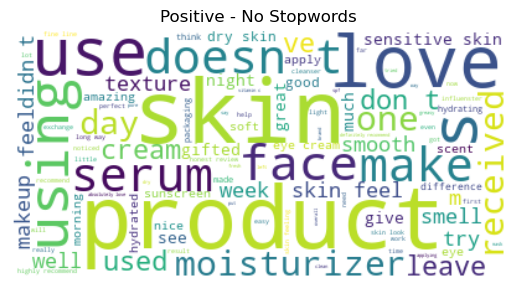

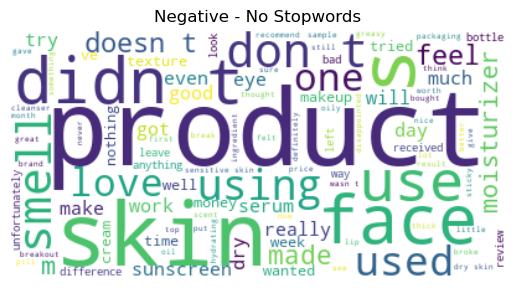

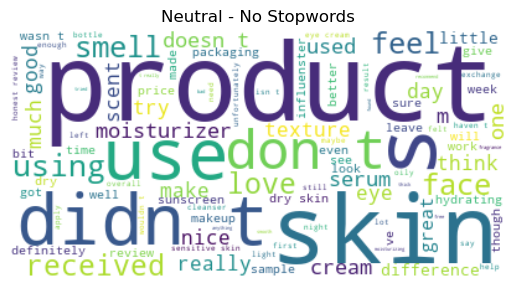

In [32]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sentiments = ['positive', 'negative', 'neutral']

for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()

    # Use the STOPWORDS set from WordCloud to exclude common stopwords
    wc1 = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=100).generate(text)

    plt.imshow(wc1, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} - No Stopwords")
    plt.show()


It has been observed that this review dataset contains a high frequency of product-related terms, such as 'skin', 'product', and 'face', across all sentiment categories. These words don't significantly influence predictions and should be classified as stopwords. 

Many reviews directly address the product; therefore, such information should be filtered out. While certain products might display predominantly positive or negative sentiments, including this data could introduce predefined biases or stereotypes about the product. Consequently, this could compromise the effectiveness of our sentiment classifier.

#### Only with Custom Stopwords

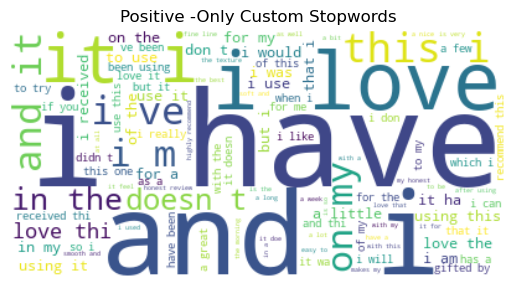

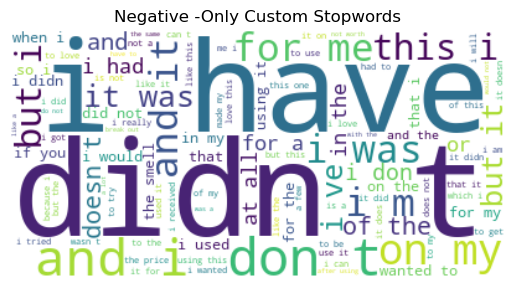

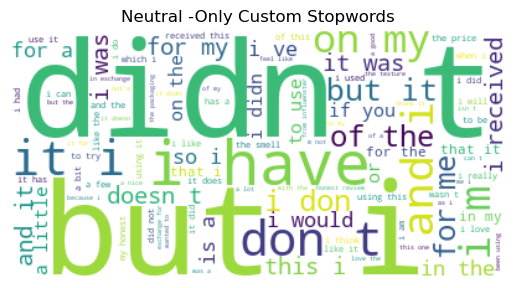

In [33]:
# draw wordcloud with custom stopword
custom_stopwords = {'skin','product','face','cream','serum','moisturizer','makeup','eye','sunscreen','eyes','products','s'}
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()
    wc2 = WordCloud(background_color="white", max_words=100, stopwords=custom_stopwords).generate(text)
    plt.imshow(wc2, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} -Only Custom Stopwords")
    plt.show()

After removing the custom stopwords from the Sephora dataset, the word cloud is dominated by typical stopwords. These don't offer insights into the three distinct sentiment categories. Therefore, additional common English stopwords should be included.

#### custom & common english stopword

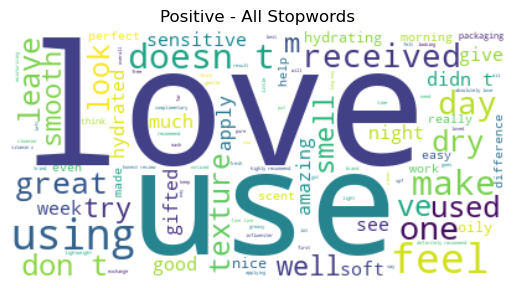

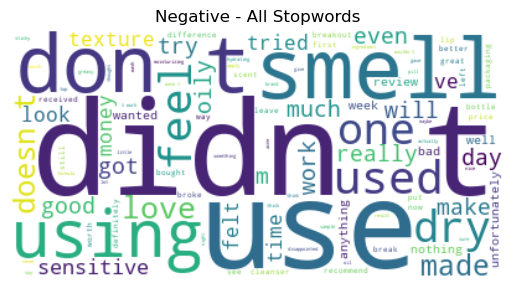

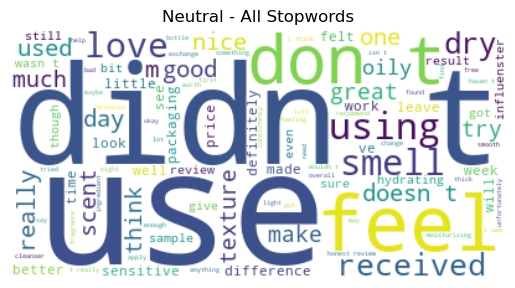

In [34]:
all_stopwords = STOPWORDS.union(custom_stopwords)
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()
    wc3 = WordCloud(background_color="white", max_words=100, stopwords=all_stopwords).generate(text)
    plt.imshow(wc3, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} - All Stopwords")
    plt.show()

With the integration of these combined stopwords, the word cloud for the three sentiments displayed a noticeable distinction. These stopwords will be referenced later in the notebook and within the Python definition

### understanding target variables/lebal: rating & is_recommended

can is_recommended be used as target variables? 

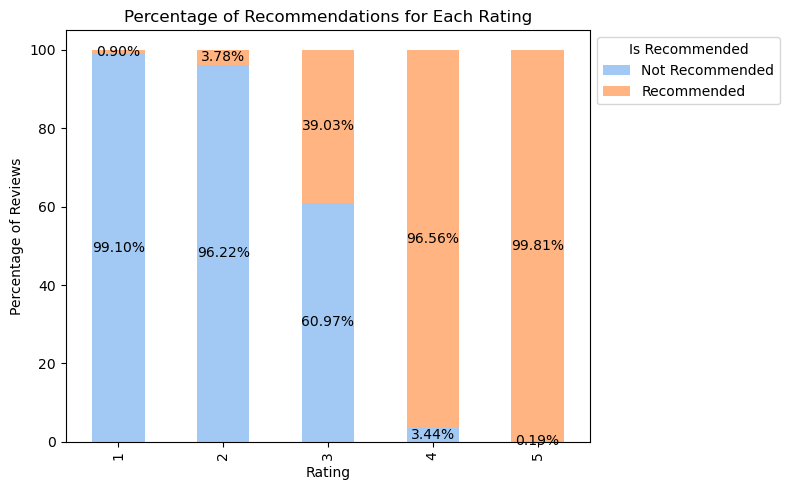

In [35]:
# understand % of is_recommended for different ratings
pivot_data = df.groupby(['rating', 'is_recommended']).size().unstack().fillna(0)
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Plotting
ax = pivot_data_percentage.plot(kind='bar', stacked=True, figsize=(8, 5), color=sns.color_palette("pastel", len(pivot_data_percentage.columns)))
ax.set_title('Percentage of Recommendations for Each Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('Percentage of Reviews')
ax.legend(title="Is Recommended", labels=["Not Recommended", "Recommended"], loc="upper left", bbox_to_anchor=(1, 1))

# Annotate with the percentage values
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x+width/2, y+height/2, f"{height:.2f}%", ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

logically, user give higher ratings would more likely to recommend certain products 
- why some users recommend a product even if they give it a rating of 1? 
- why some don't recommend a product even if they give it a rating of 5?
- is is_recommended a valuable column to use? 

To achieve objectives above:
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 1 but recommended the product.
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 5 but didn't recommend the product.
- Generate word cloud for each type

In [36]:
# sample reviews with rating 1 but recommended
recommended_with_1 = df[(df['rating'] == 1) & (df['is_recommended'] == 1)]

# Display the top 10 reviews based on helpfulness
top_5_reviews = recommended_with_1.nlargest(5, 'helpfulness')
display(top_5_reviews[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])

review_text  \
38428  Love the original, hate the refill. Purchased the refill to save some money and plastic. I followed the instructions to replace the refill and The pump no longer works and I can’t unscrew the refill to get the product out by hand. I’ve essentially wasted the $42 and my local Sephora doesn’t carry this product so I can’t exchange it. I’m just going to see if I can break the container open to salvage some of my purchase. Don’t buy the refill.   
42566                                                                                                                                                     It feels very cooling when first applied, but that’s it. It doesnt work, it doesn’t depuff, it doesn’t anything. I’ve been using it for months and I haven’t seen any change at all. It does absorb easily and the gel like texture makes it easy to apply in specific areas, but it doesn’t do anything.   
54137                                                                                                                                                                                                                                                                                                            I didn’t use this product because it did not have a safety seal when you opened it. It was just there. I prefer not to put product around my eyes.   
58368                                                                                                                                                                                                                                              I do not like the knew packaging. A lot more formula comes out, I feel like I use more product now then before before and the bottle keeps opening all together I constantly have to be Putting it back together   
62118                                                                                                                                   The product is perfect but imagine purchasing the item and have a complete reaction due to the product being expired!! Thank you Sephora for not pulling your expired items off the shelf. Expectation date May 2022 and it’s almost 2023. I returned the product for an exchange but all of them were expired!Speechless!!   

                    review_title                              product_name  \
38428                        NaN  Barrier+ Triple Lipid-Peptide Face Cream   
42566               Doesn't work    Caffeine 5% + EGCG Depuffing Eye Serum   
54137            I didn't use it       Advanced Night Repair Eye Gel-Cream   
58368     I miss the old formula         C-Firma Fresh Vitamin-C Day Serum   
62118  Check The Expiration Date      CC+ Cream Oil-Free Matte with SPF 40   

           brand_name  price_usd  
38428         Skinfix       54.0  
42566    The Ordinary        8.9  
54137    Estée Lauder       72.0  
58368  Drunk Elephant       78.0  
62118    IT Cosmetics       44.0

In [37]:
# sample reviews with rating 5 but not recommended
not_recommended_with_5 = df[(df['rating'] == 5) & (df['is_recommended'] == 0)]

# Display the top 10 reviews based on helpfulness
top_5_reviews_not_recommended = not_recommended_with_5.nlargest(5, 'helpfulness')
display(top_5_reviews_not_recommended[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])


review_text  \
1535                                                                                                                            Love this cleanser, use it every day. Very gentle on dry skin. Doesn’t take off my makeup super well so I use it as the second part of a double cleanse if I wear makeup.   
1556                                                                                                                                                                                                                                      Soft and nice. Smells almost neutral. Does not dry out my skin.   
4109   I have very sensitive, combination skin. This cleanser is the only one I’ve been able to find that has cleared my skin after one use, and keeps my skin under control all around. It’s gentle, but really deeply cleanses without over stripping it. I keep coming back to it time and time again.   
7637                                                                                                                                  Loved it deff worth the money for the full size. I don’t use it often but when my skin just need a gentle scrub this is my go to. It feels so smooth & clean after.   
14584                                                                                                                                                                          Best moisturizer for my combination skin. I’ve been using for a little over a year now and my skin has changed drastically   

      review_title                                          product_name  \
1535           NaN                    Soy Hydrating Gentle Face Cleanser   
1556           NaN                    Soy Hydrating Gentle Face Cleanser   
4109         GO TO                        Superfood Antioxidant Cleanser   
7637      Loved it                    Mini Daily Microfoliant Exfoliator   
14584          NaN  The Water Cream Oil-Free Pore Minimizing Moisturizer   

                brand_name  price_usd  
1535                 fresh       39.0  
1556                 fresh       39.0  
4109   Youth To The People       39.0  
7637           Dermalogica       18.0  
14584               Tatcha       70.0

create word cloud to understand high frequency terms

In [38]:
# Define a function to draw the word clouds
def get_word_cloud_text(df):
    return " ".join(review for review in df['review_text'])

def draw_word_cloud(text, ax, title):
    wordcloud = WordCloud(background_color="white", max_words=100, stopwords=all_stopwords).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)

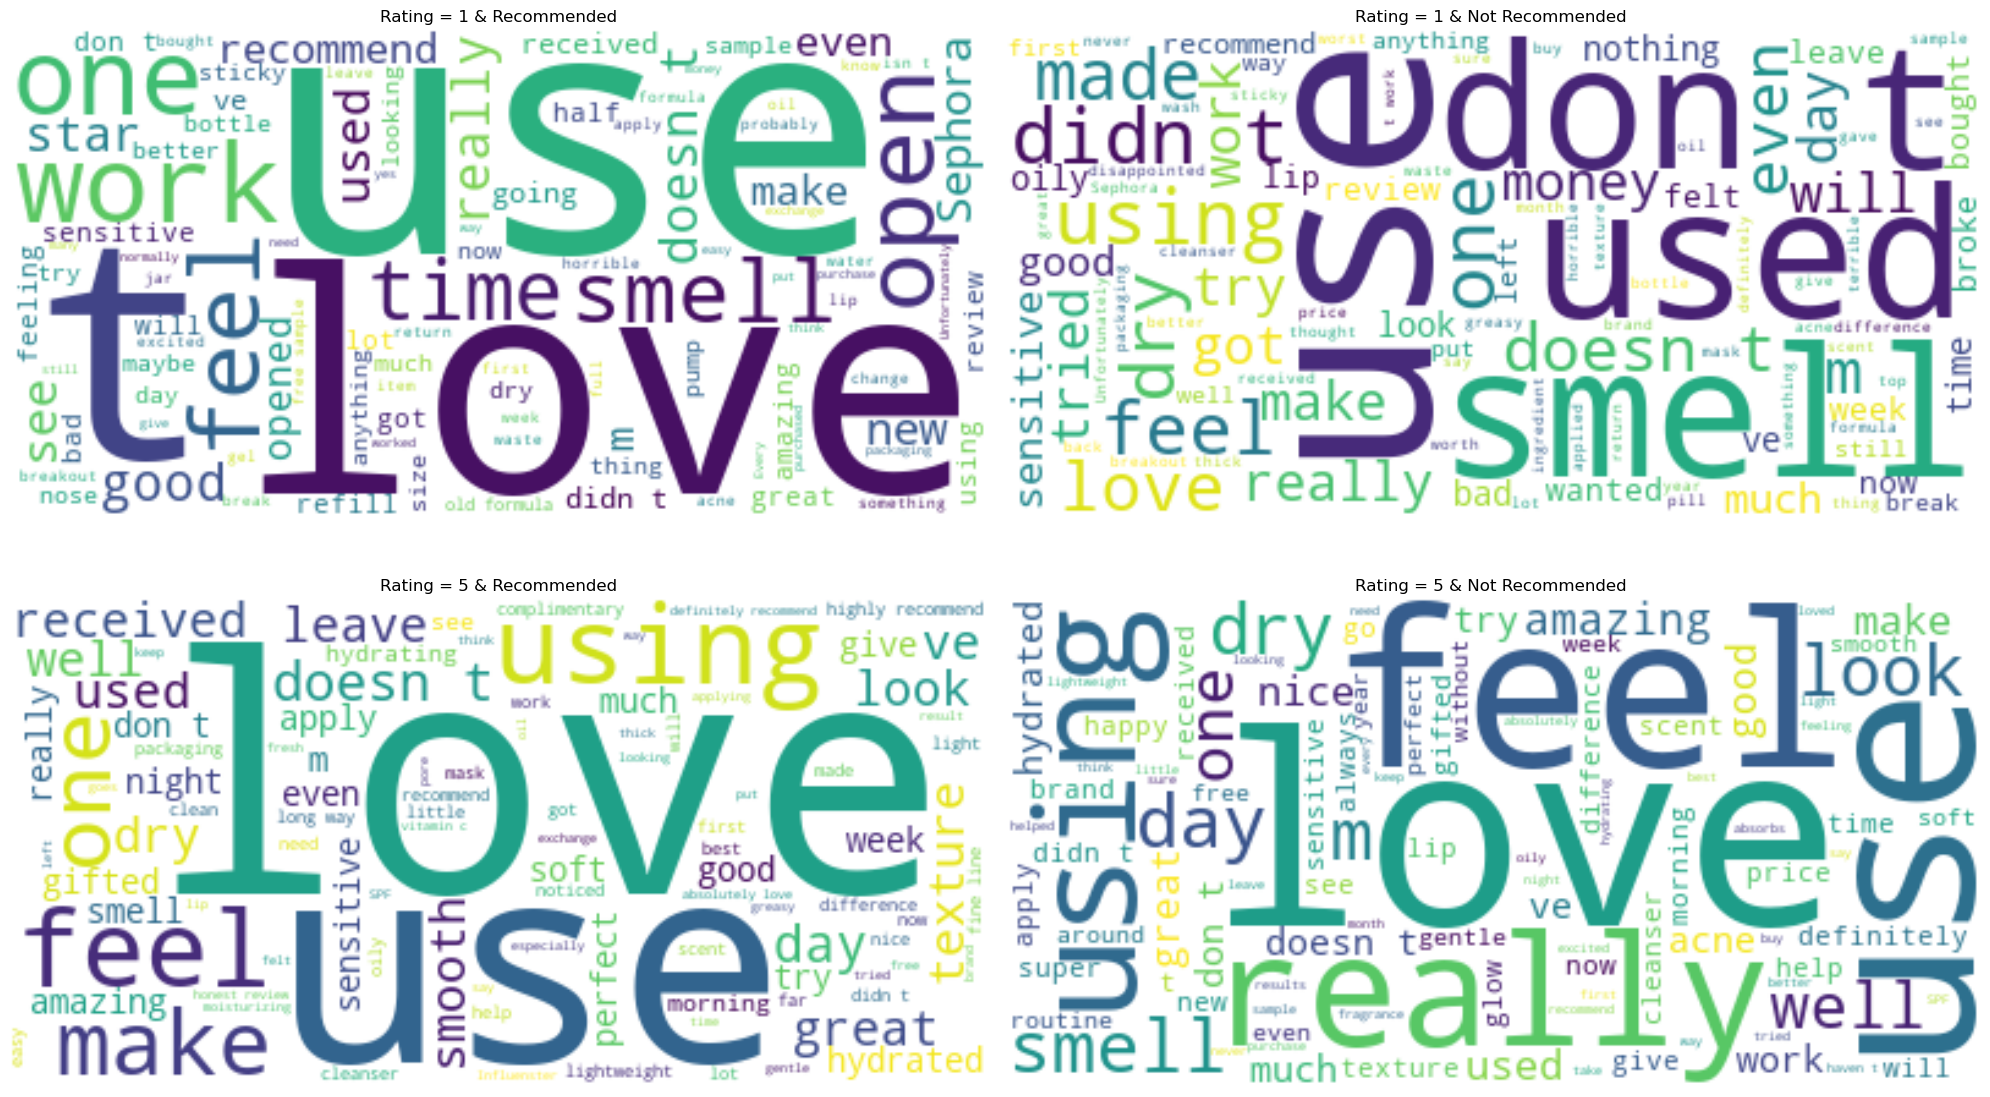

In [39]:
# get dataframe
recommended_with_5 = df[(df['rating'] == 5) & (df['is_recommended'] == 1)]
not_recommended_with_1 = df[(df['rating'] == 1) & (df['is_recommended'] == 0)]

# draw word cloud
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

draw_word_cloud(get_word_cloud_text(recommended_with_1), axs[0, 0], "Rating = 1 & Recommended")
draw_word_cloud(get_word_cloud_text(not_recommended_with_1), axs[0, 1], "Rating = 1 & Not Recommended")
draw_word_cloud(get_word_cloud_text(recommended_with_5), axs[1, 0], "Rating = 5 & Recommended")
draw_word_cloud(get_word_cloud_text(not_recommended_with_5), axs[1, 1], "Rating = 5 & Not Recommended")

plt.tight_layout()
plt.show()

looking at the sample reviews and word cloud above: 
- rating = 1 but recommended: usually has no issue with the product itself, but either services, condition of the product etc. this group of reviews should be flagged out and feedback to the relevent stakeholders. 
- rating = 5 but not recommended: generally does not show bad emotions/sentiments about the products and related services, potentially a default value = 0 when people doesnt leave an input, or put wrongly. 
- is_recommended is not a good feature to used as target variables

### understanding target variables/lebal: rating = 3

zoom onto reviews with ratings 3
- it observed that half of 3 review recommend, and the half does not
- current classfier failed to predict netural labels well
- understand the true sentiment
- is such data noise to the dataset?

To achieve above:
- some sample data
- wordcloud

In [40]:
# Filtering out reviews with ratings of 3
reviews_with_3 = df[df['rating'] == 3]

# Fetching top 10 samples for both categories
recommended_samples = reviews_with_3[reviews_with_3['is_recommended'] == 1].sample(10)
not_recommended_samples = reviews_with_3[reviews_with_3['is_recommended'] == 0].sample(10)


In [41]:
# Display the samples
pd.set_option('display.max_colwidth', None)

print("Top 10 Sample Reviews with Rating of 3 that are Recommended:")
display(recommended_samples[['review_text', 'is_recommended', 'true_sentiment']])

print("\nTop 10 Sample Reviews with Rating of 3 that are Not Recommended:")
display(not_recommended_samples[['review_text', 'is_recommended', 'true_sentiment']])

Top 10 Sample Reviews with Rating of 3 that are Recommended:


review_text  \
142472                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              This sunscreen is just ok. It works well when I am going out with no makeup on. But, under primer and makeup, it always pills/gets into the creases of my eye lines and makes the makeup chalky. I wish it would layer better, because the Supergoop Unseen Sunscreen formula is incredible, but that product isn’t mineral-based.   
190545                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    It really lives up to the claims about not not leaving a white cast and it is truly moisturizing for my dry skin. The ONLY problem with it (and the reason it’s not 5 stars) is that when I apply it around my eyes, it starts to sting and make them water…   
55010                                                                                                                                                                                                                                                                                                                                                                                                                        


Top 10 Sample Reviews with Rating of 3 that are Not Recommended:


review_text  \
181625                                                                                                                                                                                                                                                                                                                                I received this product as a free sample on my last order. I love how this moisturizer felt on my skin, it is hydrating and it absorbed well. Unfortunately, the scent is so awful it negates the benefits of the product for me. I am not scent sensitive, but this was so unpleasant I am glad the sample only lasted 2 applications...   
129983                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Was excited but disappointed, no streaks was perfectly even but it was a little too orange for me, I felt too warm, I wish it was a little cooler, but with the same depth of shade   
53908   I received this product complimentary for testing purposes through Influenster. I did find the texture of this eye cream to be particularly unique. It is slightly heavier than a typical gel texture and feels incredibly creamy and soft when applied. A word of caution: if your skin is more sensitive/reactive like mine is, I recommend trying a sample first if you are able to get your hands on one. I noticed some breakouts on my cheeks near my undereye area after I began using this eye cream which quickly went away after I discontinued use. For me, while this product is unique, the price point is too far outside of my budget for me to justify.   
88377                                                                                                                                                                                                 I love coola products generally but no where did it state this was a tinted sunscreen (comes out very beigey) and it’s very sticky on the skin (even after 15 minutes and allowing it to absorb better into my skin, still sticky) Also has an odd scent to it. Love the company and the overall ingredients and quality, this just wasn’t it and I was really looking for a good matte sunscreen like Coola used to have until the discontinued it, so I tried this one.   
1324                                                                                                                                                                                                                                                                                                                                                                                                                                             I’m giving this a fair rating because I love how it smells and I love how it feels on my lips. BUT I do think it dries my lips out. I applied this before bed and I woke up with dry, cracked skin that was peeling right off.   
176337                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    It was fine. It left my face feeling pretty sticky afterwards though.   
43097                          

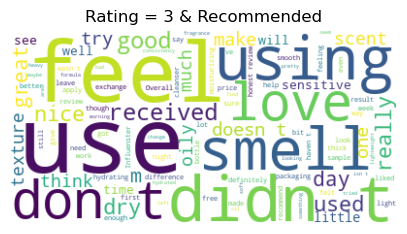

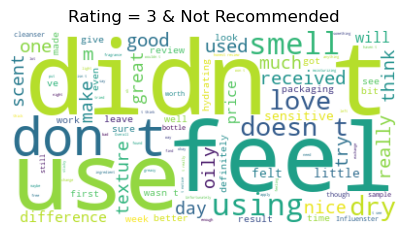

In [42]:
def generate_word_cloud(df, title):
    text = " ".join(review for review in df['review_text'])
    wordcloud = WordCloud(background_color="white", max_words=100,stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(5, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds
generate_word_cloud(reviews_with_3[reviews_with_3['is_recommended'] == 1], "Rating = 3 & Recommended")
generate_word_cloud(reviews_with_3[reviews_with_3['is_recommended'] == 0], "Rating = 3 & Not Recommended")


review with rating of 3, seems to have both negtive and positive feedbacks. Thus such reviews could be recognozied as noise to be excluded
- true neutral 
- mixture of feelings, postive towards certain asepect, negative towards certain aspect 
- showing postive or negtive sentiments 

In [43]:
# create a new dataframe df_no_3 to store only positive and negative feedbacks
df_no_3 = df[df['rating'] != 3]
pd.set_option('display.max_colwidth', 50)
df_no_3.head(3)


rating  is_recommended  helpfulness submission_time  \
1       2             0.0     0.500000      2022-12-31   
2       5             1.0     1.000000      2022-12-31   
3       4             1.0     0.333333      2022-12-31   

                                         review_text         review_title  \
1  Might as well be putting on Vaseline because I...  Where’s the smell??   
2  Love this lip mask nothing else will do Aquaph...            Must buy!   
3  I really enjoy this product! Amazing smell and...         Lovely smell   

   length                                       product_name brand_name  \
1     160  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE   
2      92  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE   
3     148  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE   

   price_usd primary_category      secondary_category tertiary_category  \
1       24.0         Skincare  Lip Balms & Treatments               NaN   
2       24.0         Skincare  Lip Balms & Treatments               NaN   
3       24.0         Skincare  Lip Balms & Treatments               NaN   

  true_sentiment                                  reviews_processed prediction  
1       negative  might as well be putting on vaseline because i...   negative  
2       positive  love this lip mask nothing else will do aquaph...   negative  
3       positive  i really enjoy this product amazing smell and ...   positive

### understanding target variables/lebal: unbalanced data

In [44]:
df_no_3.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

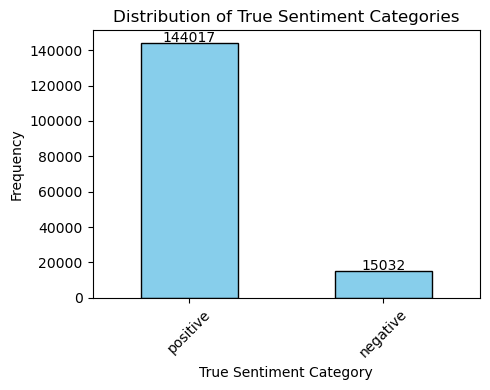

In [45]:
# check distribution of sentiments
value_counts = df_no_3['true_sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(5, 4))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
ax.set_title('Distribution of True Sentiment Categories')
ax.set_xlabel('True Sentiment Category')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45) 

# Add count numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.tight_layout()  

# Display the plot
plt.show()


In [46]:
# undersampling 

# Separate majority and minority classes
df_majority = df_no_3[df_no_3['true_sentiment'] == 'positive']
df_minority = df_no_3[df_no_3['true_sentiment'] == 'negative']

# Undersample the majority class
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)
df_undersampled = pd.concat([df_majority_undersampled, df_minority], axis=0)
df_undersampled = df_undersampled.sample(frac=1, random_state=2023).reset_index(drop=True)


In [47]:
# Subtract the undersampled majority data from the entire majority dataset
df_majority_not_used = df_majority.drop(df_majority_undersampled.index)

# If you want to store it as a CSV for future use:
# df_majority_not_used.to_csv('majority_not_used.csv', index=False)


## Model Improvement 

multiple training explorations with different: 
- training data & labels
- preprocesser
- word embedding
- features

### exploration on different training data and labels

#### train with only positive and negative labels 
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, still imbalanced
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [48]:
# training data using df_no_3
preprocessors = ['lowercase']
pn_nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = pn_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [49]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94982
Test Accuracy: 0.94711


In [50]:
# set column labels
labels = sorted(pn_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
pn_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94982
precision: 0.95205
recall: 0.94982
f1: 0.95078
f2: 0.95026

Confusion Matrix:


Predicted negative  Predicted positive
True negative                7101                1985
True positive                2804               83539

In [51]:
# get train evaluation for test set
print("\nTest:")
pn_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94711
precision: 0.94746
recall: 0.94711
f1: 0.94728
f2: 0.94718

Confusion Matrix:


Predicted negative  Predicted positive
True negative                4307                1639
True positive                1726               55948

In [52]:
new_entry = {
    'Name': 'No neutral Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews'
}

new_entry


{'Name': 'No neutral Model',
 'Train Accuracy': 0.9498160936402981,
 'Train Precision': 0.9520464565486026,
 'Train Recall': 0.9498160936402981,
 'Train F1': 0.9507786304591752,
 'Train F2': 0.9502613298173023,
 'Train Confusion Matrix': [[7101, 1985], [2804, 83539]],
 'Test Accuracy': 0.9471078277271299,
 'Test Precision': 0.9474601378915405,
 'Test Recall': 0.9471078277271299,
 'Test F1': 0.9472799362399333,
 'Test F2': 0.9471782687975793,
 'Test Confusion Matrix': [[4307, 1639], [1726, 55948]],
 'Preprocesser': ['lowercase'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews'}

In [53]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8809304987167926,
  'Train Precision': 0.8849402122354315,
  'Train Recall': 0.8809304987167926,
  'Train F1': 0.882793601091143,
  'Train F2': 0.8817295318661116,
  'Train Confusion Matrix': [[7539, 1136, 1812],
   [1489, 4203, 3106],
   [2234, 3956, 89861]],
  'Test Accuracy': 0.8706220493945975,
  'Test Precision': 0.8710576519017437,
  'Test Recall': 0.8706220493945975,
  'Test F1': 0.87080408458158,
  'Test F2': 0.8707091350384443,
  'Test Confusion Matrix': [[4496, 907, 1408],
   [1196, 2181, 2413],
   [1442, 2582, 60266]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9498160936402981,
  'Train Precision': 0.9520464565486026,
  'Train Recall': 0.9498160936402981,
  'Train F1': 0.9507786304591752,
  'Train F2': 0.9502613298173023,
  'Tr

In [54]:
# sample incorrect prediction 
visualizer = NaiveBayesVisualization(pn_nb_classifier)
visualizer.display_incorrect_samples(2)

Review: Love this lip mask nothing else will do Aquaphor and Vaseline just aren’t as moisturizing as this mask is I recommend it to everyone I know￼
Review Procrssed: love this lip mask nothing else will do aquaphor and vaseline just aren’t as moisturizing as this mask is i recommend it to everyone i know￼
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once I started using this. I had a sample from a reward or birthday gift. I will definitely keep it on hand for the future.
Review Procrssed: i had chapped lips suddenly normally not a problem for me and after several days of lip balmchapstick they only started healing once i started using this i had a sample from a reward or birthday gift i will definitely keep it on hand for the future
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I’ve used it for 2 months and honestl

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['prediction'] = self.validator.predict_batch(self.data['reviews_processed'].tolist())


The first and second review seems very positive, and there doesn't seem to be any overtly negative words that could have led to misclassification. The use of terms like "Aquaphor" and "Vaseline" might have been associated with negative sentiments in the training data, leading to the incorrect prediction.

The third review is negative in nature but contains positive words like "love" and "gloss." The model might have weighed these words more heavily leading to the misclassification. The last review has a mix of positive and negative sentiments, making it a bit trickier to classify. Words like "decent" could have contributed to the misclassification.

#### train with undersampling

#### train with undersampling dataset
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, undersampled to reach balanced data
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [55]:
# training data using df_undersampled
preprocessors = ['lowercase']
under_sample_nb_classifier = NaiveBayesClassifier(data=df_undersampled, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = under_sample_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [56]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.92854
Test Accuracy: 0.91452


In [57]:
# set column labels
labels = sorted(under_sample_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
under_sample_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.92854
precision: 0.92879
recall: 0.92854
f1: 0.92853
f2: 0.92859

Confusion Matrix:


Predicted negative  Predicted positive
True negative                8457                 536
True positive                 753                8292

In [58]:
# get train evaluation for test set
print("\nTest:")
under_sample_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.91452
precision: 0.91472
recall: 0.91452
f1: 0.91450
f2: 0.91456

Confusion Matrix:


Predicted negative  Predicted positive
True negative                5593                 446
True positive                 582                5405

In [59]:
new_entry = {
    'Name': 'Undersampled Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, balanced data with undersampling'
}

new_entry


{'Name': 'Undersampled Model',
 'Train Accuracy': 0.9285397494178955,
 'Train Precision': 0.9287929006905233,
 'Train Recall': 0.9285397494178955,
 'Train F1': 0.9285318849781681,
 'Train F2': 0.9285903686320162,
 'Train Confusion Matrix': [[8457, 536], [753, 8292]],
 'Test Accuracy': 0.9145185431564943,
 'Test Precision': 0.914722381734704,
 'Test Recall': 0.9145185431564943,
 'Test F1': 0.9145034273117888,
 'Test F2': 0.9145593036040043,
 'Test Confusion Matrix': [[5593, 446], [582, 5405]],
 'Preprocesser': ['lowercase'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, balanced data with undersampling'}

In [60]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8809304987167926,
  'Train Precision': 0.8849402122354315,
  'Train Recall': 0.8809304987167926,
  'Train F1': 0.882793601091143,
  'Train F2': 0.8817295318661116,
  'Train Confusion Matrix': [[7539, 1136, 1812],
   [1489, 4203, 3106],
   [2234, 3956, 89861]],
  'Test Accuracy': 0.8706220493945975,
  'Test Precision': 0.8710576519017437,
  'Test Recall': 0.8706220493945975,
  'Test F1': 0.87080408458158,
  'Test F2': 0.8707091350384443,
  'Test Confusion Matrix': [[4496, 907, 1408],
   [1196, 2181, 2413],
   [1442, 2582, 60266]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9498160936402981,
  'Train Precision': 0.9520464565486026,
  'Train Recall': 0.9498160936402981,
  'Train F1': 0.9507786304591752,
  'Train F2': 0.9502613298173023,
  'Tr

In [61]:
# sample incorrect prediction 
visualizer = NaiveBayesVisualization(under_sample_nb_classifier)
visualizer.display_incorrect_samples(2)

Review: I received a free sample of this face mask for review. The texture of this was really like a whipped mousse. It’s bouncy. You don’t need a lot as you will get to work rubbing in the “cookie” bits and end up spreading out the mask on your face. It took longer than I expected for the mask to be emulsified on my face and turn grey. I think a regular clay mask would do the trick as well. I did like that the mask didn’t dry out my skin and make my skin feel tight. It rinsed off easily and my skin looks clean. I didn’t love this but it was good. I have sensitive skin and didn’t experience any irritation.
Review Procrssed: i received a free sample of this face mask for review the texture of this was really like a whipped mousse it’s bouncy you don’t need a lot as you will get to work rubbing in the “cookie” bits and end up spreading out the mask on your face it took longer than i expected for the mask to be emulsified on my face and turn grey i think a regular clay mask would do the t

In [62]:
# Extract the review texts and true sentiments
X_test = df_majority_not_used['review_text'].tolist()
y_test = df_majority_not_used['true_sentiment']

from sklearn.metrics import confusion_matrix

validator=Validator(under_sample_nb_classifier)
predictions  = validator.predict_batch(texts=X_test)


In [63]:
# Compute the confusion matrix
matrix = confusion_matrix(y_test, predictions)

# Display the confusion matrix
print(matrix)

[[     0      0]
 [ 13494 115491]]


#### Conclusion

1. Normal Model:
- performs better on both training and testing data compared to the undersampling model
- difference between the training and testing metrics is less pronounced, suggesting that the model is generalizing better to unseen data than the undersampling model.
- But tends to misclassify negative reviews as positive, likely due to the imbalanced data.

2. Undersampling Model:
- slightly lower metrics than the normal model but better balanced in terms of precision and recall.
- difference between train and test metrics is higher, this suggests a bit more overfitting than undersampling model
- better performance towards negative sentiments, 

Left Over Positive Reviews: about 10% positive reviews were misclassified as negative. This might be due to the nature of the undersampling method or the inherent limitations of the Naive Bayes classifier.

3. taking Normal Model

In the competitive e-commerce sphere, Sephora values customer feedback. The normal model, with its higher accuracy and larger pool size, aligns better with Sephora's aim to cater to a broader audience. By identifying and emphasizing what's working well, the company aims to further delight our satisfied customers. The undersampling model, while effective at highlighting criticisms, leans too heavily on the negative, potentially missing out on larger pool of target audience.

Choosing the normal model allows Sephora to continuously refine its services based on a wider range of customer sentiments. It's a strategic move to ensure a broader and happier clientele, crucial for Sephora's continued success in the digital beauty marketplace.

### exploration with different stopwords preprocessor

#### train with stopword and lowercase preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, stopword
- vectorizer: count

In [64]:
# training data using df_no_3
preprocessors = ['lowercase','stopword']
sw_nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = sw_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [65]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94861
Test Accuracy: 0.94604


In [66]:
# set column labels
labels = sorted(sw_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
sw_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94861
precision: 0.94784
recall: 0.94861
f1: 0.94820
f2: 0.94846

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6474                2612
True positive                2292               84051

In [67]:
# get train evaluation for test set
print("\nTest:")
sw_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94604
precision: 0.94353
recall: 0.94604
f1: 0.94449
f2: 0.94554

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3874                2072
True positive                1361               56313

In [68]:
new_entry = {
    'Name': 'Normal Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, undersampling data, only positive and negative reviews'
}

new_entry


{'Name': 'Normal Stopword Model',
 'Train Accuracy': 0.9486110092319945,
 'Train Precision': 0.9478353120716262,
 'Train Recall': 0.9486110092319945,
 'Train F1': 0.948197956970262,
 'Train F2': 0.9484557682451284,
 'Train Confusion Matrix': [[6474, 2612], [2292, 84051]],
 'Test Accuracy': 0.9460389814523734,
 'Test Precision': 0.9435301155767077,
 'Test Recall': 0.9460389814523734,
 'Test F1': 0.9444885782066901,
 'Test F2': 0.9455361414644673,
 'Test Confusion Matrix': [[3874, 2072], [1361, 56313]],
 'Preprocesser': ['lowercase', 'stopword'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, undersampling data, only positive and negative reviews'}

In [69]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8809304987167926,
  'Train Precision': 0.8849402122354315,
  'Train Recall': 0.8809304987167926,
  'Train F1': 0.882793601091143,
  'Train F2': 0.8817295318661116,
  'Train Confusion Matrix': [[7539, 1136, 1812],
   [1489, 4203, 3106],
   [2234, 3956, 89861]],
  'Test Accuracy': 0.8706220493945975,
  'Test Precision': 0.8710576519017437,
  'Test Recall': 0.8706220493945975,
  'Test F1': 0.87080408458158,
  'Test F2': 0.8707091350384443,
  'Test Confusion Matrix': [[4496, 907, 1408],
   [1196, 2181, 2413],
   [1442, 2582, 60266]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9498160936402981,
  'Train Precision': 0.9520464565486026,
  'Train Recall': 0.9498160936402981,
  'Train F1': 0.9507786304591752,
  'Train F2': 0.9502613298173023,
  'Tr

#### train with custom_stopword and lowercase preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword
- vectorizer: count

In [70]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword']
cus_sw_nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = cus_sw_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [71]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95190
Test Accuracy: 0.94892


In [72]:
# set column labels
labels = sorted(cus_sw_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
cus_sw_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95190
precision: 0.95119
recall: 0.95190
f1: 0.95152
f2: 0.95176

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6634                2452
True positive                2138               84205

In [73]:
# get train evaluation for test set
print("\nTest:")
cus_sw_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94892
precision: 0.94649
recall: 0.94892
f1: 0.94737
f2: 0.94843

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3948                1998
True positive                1252               56422

In [74]:
new_entry = {
    'Name': 'Custom Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

new_entry


{'Name': 'Custom Stopword Model',
 'Train Accuracy': 0.9519014136164059,
 'Train Precision': 0.9511925467086471,
 'Train Recall': 0.9519014136164059,
 'Train F1': 0.9515222013045295,
 'Train F2': 0.9517595557232738,
 'Train Confusion Matrix': [[6634, 2452], [2138, 84205]],
 'Test Accuracy': 0.9489154353976736,
 'Test Precision': 0.9464932381884901,
 'Test Recall': 0.9489154353976736,
 'Test F1': 0.9473700248184328,
 'Test F2': 0.9484300046692276,
 'Test Confusion Matrix': [[3948, 1998], [1252, 56422]],
 'Preprocesser': ['lowercase', 'custom_stopword'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'}

In [75]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8809304987167926,
  'Train Precision': 0.8849402122354315,
  'Train Recall': 0.8809304987167926,
  'Train F1': 0.882793601091143,
  'Train F2': 0.8817295318661116,
  'Train Confusion Matrix': [[7539, 1136, 1812],
   [1489, 4203, 3106],
   [2234, 3956, 89861]],
  'Test Accuracy': 0.8706220493945975,
  'Test Precision': 0.8710576519017437,
  'Test Recall': 0.8706220493945975,
  'Test F1': 0.87080408458158,
  'Test F2': 0.8707091350384443,
  'Test Confusion Matrix': [[4496, 907, 1408],
   [1196, 2181, 2413],
   [1442, 2582, 60266]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9498160936402981,
  'Train Precision': 0.9520464565486026,
  'Train Recall': 0.9498160936402981,
  'Train F1': 0.9507786304591752,
  'Train F2': 0.9502613298173023,
  'Tr

#### Conclusion

Recall measures the proportion of actual negative reviews that are correctly identified. A high recall means the ability to capture a large proportion of the negative reviews, even if some positive reviews are incorrectly identified as negative. 

F2 Score weights recall higher than precision.

Given in the context of reviews, a negative review might be more concerned to the business, thus recall and F2-score should be the primary metric to look at here.

Comparing different model using different stopword preprocessor
- Model 1 (No stopwords): Train recall: 0.94623, Test recall: 0.94285
- Model 2 (Common English stopwords): Train recall: 0.94691, Test recall: 0.94367
- Model 3 (Custom stopwords): Train recall: 0.94967, Test recall: 0.94638

Model 3 not only has the highest recall but also generally performs the best in terms of accuracy, precision, F1, and F2 scores on both the training and testing datasets. There's also not a significant discrepancy between training and test scores, suggesting that overfitting is not a major concern.

Given the emphasis on maximizing recall alongside comprehensive performance metrics, Model 3 with Custom stopwords should be selected



### exploration with different text form preprocessor

#### train with lemmatizer
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword, lemmatizer
- vectorizer: count

In [76]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword','lemmatizer']
lemm_nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = lemm_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [77]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95062
Test Accuracy: 0.94760


In [78]:
# set column labels
labels = sorted(lemm_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
lemm_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95062
precision: 0.94949
recall: 0.95062
f1: 0.94999
f2: 0.95040

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6478                2608
True positive                2104               84239

In [79]:
# get train evaluation for test set
print("\nTest:")
lemm_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94760
precision: 0.94480
recall: 0.94760
f1: 0.94576
f2: 0.94704

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3851                2095
True positive                1239               56435

In [80]:
new_entry = {
    'Name': 'Lemmatizer Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, with lemmatization'
}

new_entry


{'Name': 'Lemmatizer Stopword Model',
 'Train Accuracy': 0.9506229762441186,
 'Train Precision': 0.9494867621446127,
 'Train Recall': 0.9506229762441186,
 'Train F1': 0.9499905540836409,
 'Train F2': 0.9503955159301132,
 'Train Confusion Matrix': [[6478, 2608], [2104, 84239]],
 'Test Accuracy': 0.9475950958817981,
 'Test Precision': 0.9448015265955128,
 'Test Recall': 0.9475950958817981,
 'Test F1': 0.9457557366975653,
 'Test F2': 0.9470350612109043,
 'Test Confusion Matrix': [[3851, 2095], [1239, 56435]],
 'Preprocesser': ['lowercase', 'custom_stopword', 'lemmatizer'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, with lemmatization'}

In [81]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8809304987167926,
  'Train Precision': 0.8849402122354315,
  'Train Recall': 0.8809304987167926,
  'Train F1': 0.882793601091143,
  'Train F2': 0.8817295318661116,
  'Train Confusion Matrix': [[7539, 1136, 1812],
   [1489, 4203, 3106],
   [2234, 3956, 89861]],
  'Test Accuracy': 0.8706220493945975,
  'Test Precision': 0.8710576519017437,
  'Test Recall': 0.8706220493945975,
  'Test F1': 0.87080408458158,
  'Test F2': 0.8707091350384443,
  'Test Confusion Matrix': [[4496, 907, 1408],
   [1196, 2181, 2413],
   [1442, 2582, 60266]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9498160936402981,
  'Train Precision': 0.9520464565486026,
  'Train Recall': 0.9498160936402981,
  'Train F1': 0.9507786304591752,
  'Train F2': 0.9502613298173023,
  'Tr

#### train with remove_plural preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword, remove_plural
- vectorizer: count

In [82]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword','remove_plural']
plur_nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = plur_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [83]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94994
Test Accuracy: 0.94668


In [84]:
# set column labels
labels = sorted(plur_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
plur_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94994
precision: 0.94883
recall: 0.94994
f1: 0.94933
f2: 0.94972

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6456                2630
True positive                2147               84196

In [85]:
# get train evaluation for test set
print("\nTest:")
plur_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94668
precision: 0.94386
recall: 0.94668
f1: 0.94485
f2: 0.94612

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3829                2117
True positive                1275               56399

In [86]:
new_entry = {
    'Name': 'remove plural Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, remove_plural'
}

new_entry


{'Name': 'remove plural Stopword Model',
 'Train Accuracy': 0.9499418415785558,
 'Train Precision': 0.9488320199530003,
 'Train Recall': 0.9499418415785558,
 'Train F1': 0.9493282306237418,
 'Train F2': 0.9497196696017728,
 'Train Confusion Matrix': [[6456, 2630], [2147, 84196]],
 'Test Accuracy': 0.9466834328827413,
 'Test Precision': 0.9438561295497173,
 'Test Recall': 0.9466834328827413,
 'Test F1': 0.9448452817440546,
 'Test F2': 0.9461166179660058,
 'Test Confusion Matrix': [[3829, 2117], [1275, 56399]],
 'Preprocesser': ['lowercase', 'custom_stopword', 'remove_plural'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, remove_plural'}

In [87]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8809304987167926,
  'Train Precision': 0.8849402122354315,
  'Train Recall': 0.8809304987167926,
  'Train F1': 0.882793601091143,
  'Train F2': 0.8817295318661116,
  'Train Confusion Matrix': [[7539, 1136, 1812],
   [1489, 4203, 3106],
   [2234, 3956, 89861]],
  'Test Accuracy': 0.8706220493945975,
  'Test Precision': 0.8710576519017437,
  'Test Recall': 0.8706220493945975,
  'Test F1': 0.87080408458158,
  'Test F2': 0.8707091350384443,
  'Test Confusion Matrix': [[4496, 907, 1408],
   [1196, 2181, 2413],
   [1442, 2582, 60266]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9498160936402981,
  'Train Precision': 0.9520464565486026,
  'Train Recall': 0.9498160936402981,
  'Train F1': 0.9507786304591752,
  'Train F2': 0.9502613298173023,
  'Tr

#### conclusion

Although Model 2 (with lemmatization) slightly outperforms the others in terms of recall and the F2 score, the difference is marginal. 

The consistent performance of all three models between training and testing indicates that overfitting is not an evident concern. 

Given that lemmatization requires a longer processing time, a simple base model might suffice


### exploration with different vectorization method

#### train with tfidf instead of count
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword
- vectorizer: tfidf

In [88]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword']
tfidf_nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = tfidf_nb_classifier.train(vectorizer_type='tfidf', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [89]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.91206
Test Accuracy: 0.91070


In [90]:
# set column labels
labels = sorted(tfidf_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
tfidf_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.91206
precision: 0.90863
recall: 0.91206
f1: 0.87825
f2: 0.91137

Confusion Matrix:


Predicted negative  Predicted positive
True negative                 813                8273
True positive                 119               86224

In [91]:
# get train evaluation for test set
print("\nTest:")
tfidf_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.91070
precision: 0.91183
recall: 0.91070
f1: 0.87260
f2: 0.91093

Confusion Matrix:


Predicted negative  Predicted positive
True negative                 289                5657
True positive                  24               57650

In [92]:
new_entry = {
    'Name': 'TFIDF Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'tfidf',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

new_entry


{'Name': 'TFIDF Model',
 'Train Accuracy': 0.9120602751784049,
 'Train Precision': 0.9086309408989963,
 'Train Recall': 0.9120602751784049,
 'Train F1': 0.8782542515745551,
 'Train F2': 0.9113723390180081,
 'Train Confusion Matrix': [[813, 8273], [119, 86224]],
 'Test Accuracy': 0.9107041810751336,
 'Test Precision': 0.9118269641057631,
 'Test Recall': 0.9107041810751336,
 'Test F1': 0.872600628561117,
 'Test F2': 0.9109285164195825,
 'Test Confusion Matrix': [[289, 5657], [24, 57650]],
 'Preprocesser': ['lowercase', 'custom_stopword'],
 'Vectorizer': 'tfidf',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'}

In [93]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8809304987167926,
  'Train Precision': 0.8849402122354315,
  'Train Recall': 0.8809304987167926,
  'Train F1': 0.882793601091143,
  'Train F2': 0.8817295318661116,
  'Train Confusion Matrix': [[7539, 1136, 1812],
   [1489, 4203, 3106],
   [2234, 3956, 89861]],
  'Test Accuracy': 0.8706220493945975,
  'Test Precision': 0.8710576519017437,
  'Test Recall': 0.8706220493945975,
  'Test F1': 0.87080408458158,
  'Test F2': 0.8707091350384443,
  'Test Confusion Matrix': [[4496, 907, 1408],
   [1196, 2181, 2413],
   [1442, 2582, 60266]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9498160936402981,
  'Train Precision': 0.9520464565486026,
  'Train Recall': 0.9498160936402981,
  'Train F1': 0.9507786304591752,
  'Train F2': 0.9502613298173023,
  'Tr

BOW(count vector) preforms better than TFIDF. This is uncommon. 
- Nature of Reviews: TF-IDF is designed to reduce the weight of words that appear frequently across all reviews, which might be beneficial if those words don't carry significant sentiment value. However, this can also be a double-edged sword; if certain frequent words do have significant sentiment implications, TF-IDF could inadvertently diminish their importance.
- Product Specificity: Since Sephora reviews will span a multitude of products, certain terms might be crucial to one product but not to another. TF-IDF will amplify these product-specific terms, while Count Vectorization will treat them just like any other term.

### bigram

In [94]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword']
bi_nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = bi_nb_classifier.train(vectorizer_type='count', use_additional_features=False,bi_gram=True)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [95]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95190
Test Accuracy: 0.94892


In [96]:
# set column labels
labels = sorted(bi_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
bi_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95190
precision: 0.95119
recall: 0.95190
f1: 0.95152
f2: 0.95176

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6634                2452
True positive                2138               84205

In [97]:
# get train evaluation for test set
print("\nTest:")
bi_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94892
precision: 0.94649
recall: 0.94892
f1: 0.94737
f2: 0.94843

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3948                1998
True positive                1252               56422

In [98]:
new_entry = {
    'Name': 'bigram Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'bigram, no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

new_entry


{'Name': 'bigram Model',
 'Train Accuracy': 0.9519014136164059,
 'Train Precision': 0.9511925467086471,
 'Train Recall': 0.9519014136164059,
 'Train F1': 0.9515222013045295,
 'Train F2': 0.9517595557232738,
 'Train Confusion Matrix': [[6634, 2452], [2138, 84205]],
 'Test Accuracy': 0.9489154353976736,
 'Test Precision': 0.9464932381884901,
 'Test Recall': 0.9489154353976736,
 'Test F1': 0.9473700248184328,
 'Test F2': 0.9484300046692276,
 'Test Confusion Matrix': [[3948, 1998], [1252, 56422]],
 'Preprocesser': ['lowercase', 'custom_stopword'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'bigram, no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'}

### exploration on additional features

#### train with additional features
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: all features 
- preprocessor: lowercase, custom_stopword
- vectorizer: count

In [99]:
df_no_3.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

In [100]:
df_additional_features = df_no_3[['review_text','helpfulness', 'length', 'true_sentiment','price_usd']]

In [101]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword']
add_nb_classifier = NaiveBayesClassifier(data=df_additional_features, text_col='review_text', preprocessors=preprocessors)


In [102]:
train_metrics, test_metrics = add_nb_classifier.train(vectorizer_type='count', use_additional_features=True)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [103]:
# # get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95190
Test Accuracy: 0.94892


In [104]:
# # set column labels
labels = sorted(add_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
add_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95190
precision: 0.95119
recall: 0.95190
f1: 0.95152
f2: 0.95176

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6634                2452
True positive                2138               84205

In [105]:
# # get train evaluation for test set
print("\nTest:")
add_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94892
precision: 0.94649
recall: 0.94892
f1: 0.94737
f2: 0.94843

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3948                1998
True positive                1252               56422

In [106]:
new_entry = {
    'Name': 'Additional Feature Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text, helpfulness, length, price_usd',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

new_entry


{'Name': 'Additional Feature Model',
 'Train Accuracy': 0.9519014136164059,
 'Train Precision': 0.9511925467086471,
 'Train Recall': 0.9519014136164059,
 'Train F1': 0.9515222013045295,
 'Train F2': 0.9517595557232738,
 'Train Confusion Matrix': [[6634, 2452], [2138, 84205]],
 'Test Accuracy': 0.9489154353976736,
 'Test Precision': 0.9464932381884901,
 'Test Recall': 0.9489154353976736,
 'Test F1': 0.9473700248184328,
 'Test F2': 0.9484300046692276,
 'Test Confusion Matrix': [[3948, 1998], [1252, 56422]],
 'Preprocesser': ['lowercase', 'custom_stopword'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text, helpfulness, length, price_usd',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'}

In [107]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8809304987167926,
  'Train Precision': 0.8849402122354315,
  'Train Recall': 0.8809304987167926,
  'Train F1': 0.882793601091143,
  'Train F2': 0.8817295318661116,
  'Train Confusion Matrix': [[7539, 1136, 1812],
   [1489, 4203, 3106],
   [2234, 3956, 89861]],
  'Test Accuracy': 0.8706220493945975,
  'Test Precision': 0.8710576519017437,
  'Test Recall': 0.8706220493945975,
  'Test F1': 0.87080408458158,
  'Test F2': 0.8707091350384443,
  'Test Confusion Matrix': [[4496, 907, 1408],
   [1196, 2181, 2413],
   [1442, 2582, 60266]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9498160936402981,
  'Train Precision': 0.9520464565486026,
  'Train Recall': 0.9498160936402981,
  'Train F1': 0.9507786304591752,
  'Train F2': 0.9502613298173023,
  'Tr

## model comparision

In [108]:
compare_df = pd.DataFrame(results_list)
compare_df[['Name','Test Accuracy','Test Precision', 'Test Recall', 'Test F2', 'Test Confusion Matrix']].sort_values(by='Test F2', ascending=False)


Name  Test Accuracy  Test Precision  Test Recall  \
4         Custom Stopword Model       0.948915        0.946493     0.948915   
8      Additional Feature Model       0.948915        0.946493     0.948915   
1              No neutral Model       0.947108        0.947460     0.947108   
5     Lemmatizer Stopword Model       0.947595        0.944802     0.947595   
6  remove plural Stopword Model       0.946683        0.943856     0.946683   
3         Normal Stopword Model       0.946039        0.943530     0.946039   
2            Undersampled Model       0.914519        0.914722     0.914519   
7                   TFIDF Model       0.910704        0.911827     0.910704   
0                Baseline Model       0.870622        0.871058     0.870622   

    Test F2                              Test Confusion Matrix  
4  0.948430                      [[3948, 1998], [1252, 56422]]  
8  0.948430                      [[3948, 1998], [1252, 56422]]  
1  0.947178                      [[4307, 1639], [1726, 55948]]  
5  0.947035                      [[3851, 2095], [1239, 56435]]  
6  0.946117                      [[3829, 2117], [1275, 56399]]  
3  0.945536                      [[3874, 2072], [1361, 56313]]  
2  0.914559                         [[5593, 446], [582, 5405]]  
7  0.910929                         [[289, 5657], [24, 57650]]  
0  0.870709  [[4496, 907, 1408], [1196, 2181, 2413], [1442,...

In [109]:
# # save to csv
# compare_df.to_csv('compare_metrics.csv', index=False)

No neutral Model is the best

In [110]:
visualizer.show_top_features(10)

UnboundLocalError: local variable 'output_str' referenced before assignment

In [111]:
# sample incorrect prediction 
visualizer = NaiveBayesVisualization(pn_nb_classifier)
visualizer.display_incorrect_samples(2)

Review: Love this lip mask nothing else will do Aquaphor and Vaseline just aren’t as moisturizing as this mask is I recommend it to everyone I know￼
Review Procrssed: love lip mask nothing will aquaphor vaseline aren’t moisturizing mask recommend everyone know￼
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once I started using this. I had a sample from a reward or birthday gift. I will definitely keep it on hand for the future.
Review Procrssed: chapped lips suddenly normally problem several days lip balmchapstick started healing started using sample reward birthday gift will definitely keep hand future
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I’ve used it for 2 months and honestly it’s made my lips more chapped. I love the smell/ feel/ look, but I does nothing moisturizer the lips. I use it more like a lip glos

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['prediction'] = self.validator.predict_batch(self.data['reviews_processed'].tolist())


In [112]:
# set column labels
labels = sorted(pn_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
pn_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df



Train:
accuracy: 0.95190
precision: 0.95119
recall: 0.95190
f1: 0.95152
f2: 0.95176

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6634                2452
True positive                2138               84205

In [113]:
# get train evaluation for test set
print("\nTest:")
pn_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94892
precision: 0.94649
recall: 0.94892
f1: 0.94737
f2: 0.94843

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3948                1998
True positive                1252               56422


Confusion Matrix:
               Predicted negative  Predicted positive
True negative                3948                1998
True positive                1252               56422


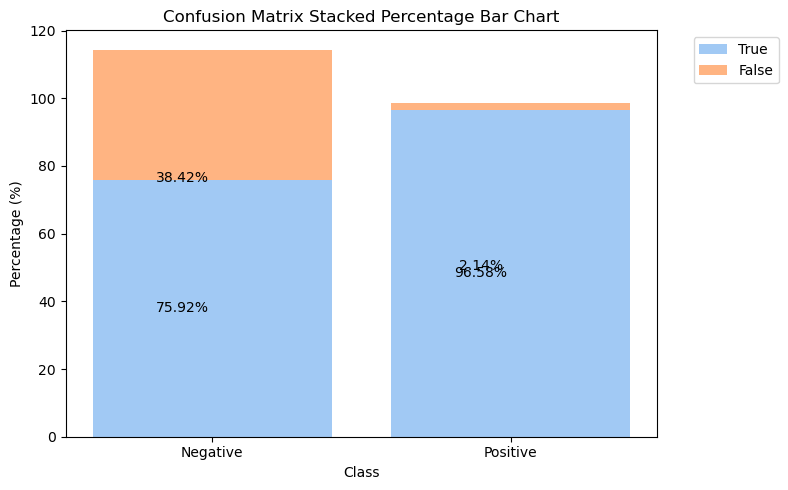

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that you're using the Pastel color palette
sns.set_palette("pastel")

# Given confusion matrix
print("\nConfusion Matrix:")
print(confusion_df)

# Stacked bar chart for confusion matrix
true_values = [confusion_df.loc["True negative", "Predicted negative"], confusion_df.loc["True positive", "Predicted positive"]]
false_values = [confusion_df.loc["True negative", "Predicted positive"], confusion_df.loc["True positive", "Predicted negative"]]
bar_labels = ["Negative", "Positive"]

# Calculate percentages
total_neg = sum(confusion_df["Predicted negative"])
total_pos = sum(confusion_df["Predicted positive"])
true_percentage = [true_values[0] / total_neg * 100, true_values[1] / total_pos * 100]
false_percentage = [false_values[0] / total_neg * 100, false_values[1] / total_pos * 100]

# Get the colors from the Pastel palette
colors = sns.color_palette("pastel", n_colors=2)

plt.figure(figsize=(8, 5))
bars1 = plt.bar(bar_labels, true_percentage, label="True", color=colors[0])
bars2 = plt.bar(bar_labels, false_percentage, bottom=true_percentage, label="False", color=colors[1])

# Add percentage labels to the bars
for i, (bar, true_perc, false_perc) in enumerate(zip(bars1, true_percentage, false_percentage)):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2, f"{true_perc:.2f}%", ha='center', va='center', color='black')
    plt.text(bars2[i].get_x() + bars2[i].get_width() / 2 - 0.1, bars2[i].get_height() + true_perc / 2, f"{false_perc:.2f}%", ha='center', va='center', color='black')

plt.title('Confusion Matrix Stacked Percentage Bar Chart')
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()



Confusion Matrix:
               Predicted negative  Predicted positive
True negative                3948                1998
True positive                1252               56422


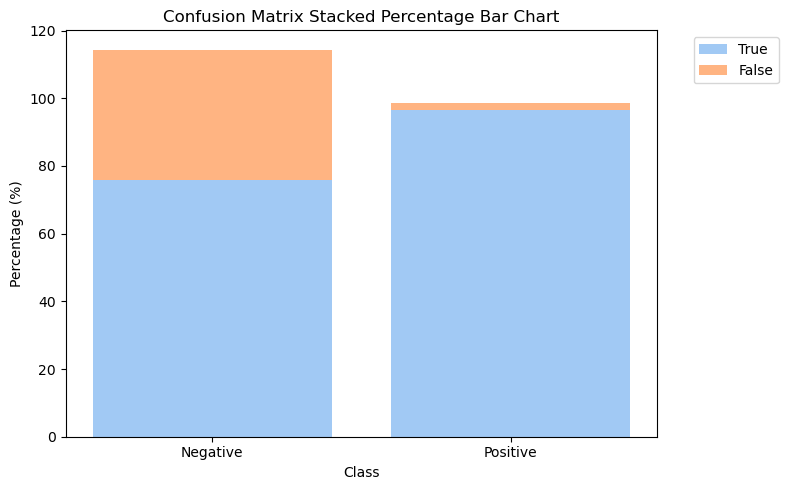

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that you're using the Pastel color palette
sns.set_palette("pastel")

# Given confusion matrix
print("\nConfusion Matrix:")
print(confusion_df)

# Stacked bar chart for confusion matrix
true_values = [confusion_df.loc["True negative", "Predicted negative"], confusion_df.loc["True positive", "Predicted positive"]]
false_values = [confusion_df.loc["True negative", "Predicted positive"], confusion_df.loc["True positive", "Predicted negative"]]
bar_labels = ["Negative", "Positive"]

# Calculate percentages
total_neg = sum(confusion_df["Predicted negative"])
total_pos = sum(confusion_df["Predicted positive"])
true_percentage = [true_values[0] / total_neg * 100, true_values[1] / total_pos * 100]
false_percentage = [false_values[0] / total_neg * 100, false_values[1] / total_pos * 100]

# Get the colors from the Pastel palette
colors = sns.color_palette("pastel", n_colors=2)

plt.figure(figsize=(8, 5))
bars1 = plt.bar(bar_labels, true_percentage, label="True", color=colors[0])
bars2 = plt.bar(bar_labels, false_percentage, bottom=true_percentage, label="False", color=colors[1])
plt.title('Confusion Matrix Stacked Percentage Bar Chart')
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # This line places the legend outside the plot
plt.tight_layout()
plt.show()


['love', 'it', 'use', 'using', 'really', 'great', 'feel', 've', 'feels', 'dry', 'definitely', 'one', 'recommend', 'well', 'will', 'good', 'used', 'texture', 'doesn', 'nice']


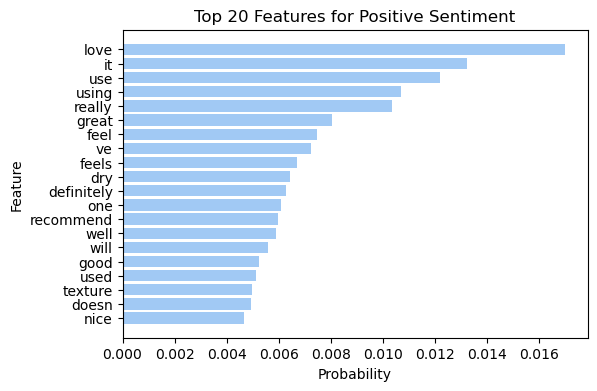

['it', 'really', 'use', 'didn', 'using', 'used', 'don', 'dry', 'one', 'love', 've', 'even', 'smell', 'much', 'doesn', 'feel', 'good', 'made', 'work', 'will']


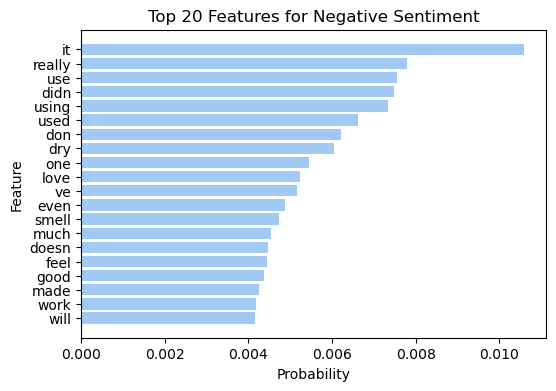

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the MultinomialNB classifier from the pipeline
mnb_classifier = cus_sw_nb_classifier.classifier.named_steps['classifier']

# Convert log probabilities to regular probabilities
probs = np.exp(mnb_classifier.feature_log_prob_)

# Get the vectorizer from the pipeline to access feature names
vectorizer = cus_sw_nb_classifier.classifier.named_steps['vectorizer']
feature_names = vectorizer.get_feature_names_out()

# Map class names to indices
class_indices = {label: index for index, label in enumerate(mnb_classifier.classes_)}

def plot_top_features_for_class(class_name):
    class_index = class_indices[class_name]
    
    # Get top 20 feature indices and their probabilities
    sorted_indices = probs[class_index].argsort()[::-1][:20]
    top_probs = probs[class_index][sorted_indices]
    top_features = [feature_names[i] for i in sorted_indices]
    print(top_features)

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(top_features, top_probs, align='center')
    plt.xlabel('Probability')
    plt.ylabel('Feature')
    plt.title(f'Top 20 Features for {class_name.capitalize()} Sentiment')
    plt.gca().invert_yaxis()  # To display the highest probability at the top
    plt.show()

plot_top_features_for_class("positive")
plot_top_features_for_class("negative")


## manual validation

In [123]:
# to set up an interactive sentiment prediction function
def interactive_sentiment_prediction(validator_instance):
    text = input("Enter the text for validation: ")
    prediction = validator_instance.predict_single(text)
    print(f"The predicted sentiment for the given text is: {prediction}")


In [124]:
# Once the classifier is trained, create an instance of the visualization class
visualization = NaiveBayesVisualization(under_sample_nb_classifier)
# Create an instance of Validator
validator = Validator(pn_nb_classifier)


In [125]:
# Define a function to input text and see the sentiment
def interactive_sentiment_prediction(validator):
    text = input("Enter the text for sentiment analysis: ")
    # Process and predict the sentiment
    prediction = validator.predict_single(text)
    # Output the result
    print(f"The predicted sentiment for the given text is: {prediction}")

In [ ]:
# this is an interactive vaildation function, please uncomment to play around 
# # Now you can call the function to input text and get predictions
# interactive_sentiment_prediction(validator)

overall, model preforms good, but there are some instance where the model is not so good at predicting
- mixture of feeling: 'delivery is way to slow, but product is good' how do i know each sentiment is tag to which service 
- negtive expression: i expected it to be much better

In [132]:
text = 'delivery is way to slow, but product is good' 
prediction = validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

The predicted sentiment for the given text is: positive


In [133]:
text = 'I expected this product to be better' 
prediction = validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

The predicted sentiment for the given text is: positive


## Advanced Analysis

- mixture of feeling: 'delivery is way to slow, but product is good' - > how do i know each sentiment is tagged to which aespect?
- negative expression:   ‘i expected it to be much better’ - > especially shorten reviews, the nature of nb wont provide enough context. 


In [134]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



In [135]:
aspects = ["delivery", "product"]

def identify_aspects_and_sentiments_with_model(sentence, validator):
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)
    
    # Identify aspects in the sentence
    identified_aspects = [token for token in tokens if token in aspects]
    
    # For each aspect, extract context and predict sentiment using the trained model
    aspect_sentiments = {}
    for aspect in identified_aspects:
        # Find the index of the aspect in tokens
        aspect_index = tokens.index(aspect)
        
        # Consider 3 words before and after the aspect as context
        context = tokens[max(0, aspect_index - 3):aspect_index] + tokens[aspect_index + 1:min(aspect_index + 4, len(tokens))]
        
        # Predict sentiment for the context using the model
        sentiment = validator.predict_single(' '.join(context))
        
        aspect_sentiments[aspect] = sentiment
    
    return aspect_sentiments

# Test the function
sentence = "delivery is way too slow, but product is good"
print(identify_aspects_and_sentiments_with_model(sentence, validator))


{'delivery': 'positive', 'product': 'positive'}


In [136]:
aspects = ["delivery", "product"]

def extract_adj_using_pos(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    
    # Extract adjectives and their preceding words
    adj_contexts = []
    for index, (word, pos) in enumerate(tagged):
        if pos == "JJ" and index > 0:
            adj_contexts.append((tagged[index - 1][0], word))
    return adj_contexts

def identify_aspects_and_sentiments_with_pos(sentence, validator):
    adj_contexts = extract_adj_using_pos(sentence)
    
    aspect_sentiments = {}
    for context in adj_contexts:
        # If the preceding word is an aspect of interest
        if context[0] in aspects:
            # Predict sentiment for the context using the model
            sentiment = validator.predict_single(' '.join(context))
            aspect_sentiments[context[0]] = sentiment

    return aspect_sentiments

In [140]:
# Test the function
sentence = "delivery is way too slow, but product is good"
print(identify_aspects_and_sentiments_with_pos(sentence, validator))

{'product': 'positive'}


In [185]:
import nltk
from nltk.tokenize import word_tokenize

aspects = ["delivery", "product"]

def extract_adj_using_pos(sentence):
    tokens = word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    
    # Extract adjectives and nearby words
    adj_contexts = {}
    for index, (word, pos) in enumerate(tagged):
        if pos == "JJ":
            context = tokens[max(0, index - 3):index + 4]  # taking a larger window
            adj_contexts[word] = context
    return adj_contexts

def identify_aspects_and_sentiments_with_pos(sentence, validator):
    adj_contexts = extract_adj_using_pos(sentence)
    
    aspect_sentiments = {}
    for adj, context in adj_contexts.items():
        for aspect in aspects:
            if aspect in context:
                # Predict sentiment for the context using the model
                combined_text = ' '.join(context)
                sentiment = validator.predict_single(combined_text)
                aspect_sentiments[aspect] = sentiment

    return aspect_sentiments

# Test the function
sentence = "delivery is way too slow, but product is good"
print(identify_aspects_and_sentiments_with_pos(sentence, validator))


{'product': 'positive'}


In [182]:
import spacy
from spacy import displacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def get_aspect_sentiments(sentence, validator):
    # Parse the sentence using spaCy
    doc = nlp(sentence)
    
    # Visualizing the dependency tree (optional but can be helpful)
    # displacy.serve(doc, style="dep")
    
    aspect_sentiments = {}
    
    # Traverse through tokens
    for token in doc:
        # Check if the token is an adjective or a verb indicating sentiment
        if token.pos_ in ['ADJ', 'VERB']:
            # Traverse up the tree to find the associated noun
            for child in token.children:
                if child.pos_ == 'NOUN' and child.text in aspects:
                    # Predict sentiment
                    sentiment = validator.predict_single(token.text)
                    aspect_sentiments[child.text] = sentiment
    return aspect_sentiments

# Define your aspects
aspects = ["delivery", "product"]

# Test the function
sentence = "delivery is way too slow, but product is good"
results = get_aspect_sentiments(sentence, validator)
print(results)


AttributeError: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

In [ ]:
y

Dealing with mixed sentiments and nuanced expressions in text is challenging for many sentiment analysis models. However, there are several strategies you can employ to improve your model's performance in such scenarios:

In [141]:
latest_review.head(3)

rating  is_recommended  helpfulness submission_time  \
0       3             0.0     0.714286      2022-12-31   
1       2             0.0     0.500000      2022-12-31   
2       5             1.0     1.000000      2022-12-31   

                                         review_text  \
0  I decided to try this as I had never used a li...   
1  Might as well be putting on Vaseline because I...   
2  Love this lip mask nothing else will do Aquaph...   

                                review_title  length  \
0  Decent, but cheaper products do the trick     172   
1                        Where’s the smell??     160   
2                                  Must buy!      92   

                                        product_name brand_name  price_usd  \
0  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE       24.0   
1  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE       24.0   
2  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE       24.0   

  primary_category      secondary_category tertiary_category true_sentiment  \
0         Skincare  Lip Balms & Treatments               NaN        neutral   
1         Skincare  Lip Balms & Treatments               NaN       negative   
2         Skincare  Lip Balms & Treatments               NaN       positive   

                                   reviews_processed prediction  
0  i decided to try this as i had never used a li...    neutral  
1  might as well be putting on vaseline because i...   negative  
2  love this lip mask nothing else will do aquaph...   negative

In [262]:
df_neutral=latest_review[latest_review['true_sentiment']=='neutral']

In [151]:
X_test=df_neutral['review_text'].tolist()


In [170]:
validator=Validator(pn_nb_classifier)
predictions  = validator.predict_batch(texts=X_test)


In [171]:
predictions
len(predictions)

14588

/var/folders/8z/fr1y76rn6js5w526_mc9y1hh0000gn/T/ipykernel_37633/1154733791.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neutral['predictions'] = predictions


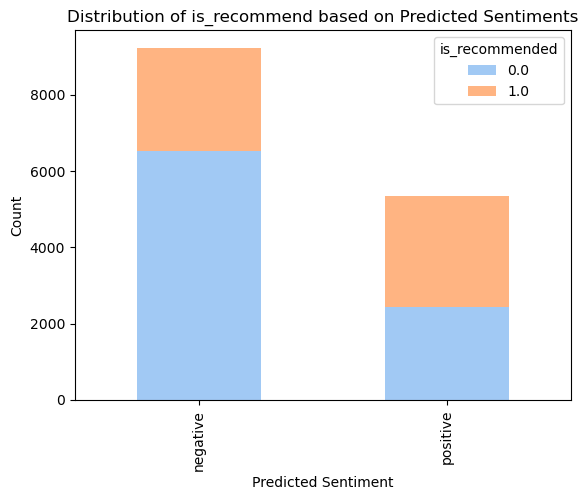

In [177]:
validator=Validator(under_sample_nb_classifier)
predictions  = validator.predict_batch(texts=X_test)


# Assuming df_neutral already has an 'is_recommend' column

# 1. Add predictions to the dataframe
df_neutral['predictions'] = predictions

# 2. Group by predictions and is_recommend values
grouped = df_neutral.groupby(['predictions', 'is_recommended']).size().unstack()

# 3. Plot the bar chart
grouped.plot(kind='bar', stacked=True)

plt.title('Distribution of is_recommend based on Predicted Sentiments')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.show()


/var/folders/8z/fr1y76rn6js5w526_mc9y1hh0000gn/T/ipykernel_37633/1450627661.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neutral['predictions'] = predictions


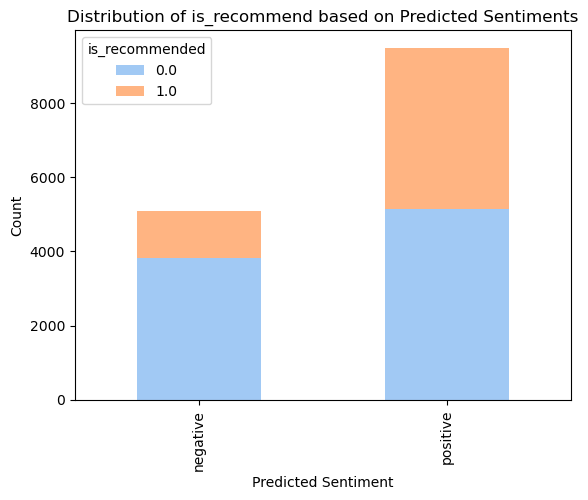

In [178]:
validator=Validator(pn_nb_classifier)
predictions  = validator.predict_batch(texts=X_test)


# Assuming df_neutral already has an 'is_recommend' column

# 1. Add predictions to the dataframe
df_neutral['predictions'] = predictions

# 2. Group by predictions and is_recommend values
grouped = df_neutral.groupby(['predictions', 'is_recommended']).size().unstack()

# 3. Plot the bar chart
grouped.plot(kind='bar', stacked=True)

plt.title('Distribution of is_recommend based on Predicted Sentiments')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.show()


### not_recommended_with_5


In [179]:
not_recommended_with_5.head(3)

rating  is_recommended  helpfulness submission_time  \
1535       5             0.0          1.0      2022-01-27   
1556       5             0.0          1.0      2022-01-06   
2871       5             0.0          NaN      2022-03-09   

                                            review_text review_title  length  \
1535  Love this cleanser, use it every day. Very gen...          NaN     116   
1556  Soft and nice. Smells almost neutral. Does not...          NaN      39   
2871  It’s perfect. It is first time for me that cle...          NaN     111   

                                    product_name brand_name  price_usd  \
1535          Soy Hydrating Gentle Face Cleanser      fresh       39.0   
1556          Soy Hydrating Gentle Face Cleanser      fresh       39.0   
2871  Green Clean Makeup Removing Cleansing Balm    Farmacy       36.0   

     primary_category secondary_category      tertiary_category  \
1535         Skincare          Cleansers  Face Wash & Cleansers   
1556         Skincare          Cleansers  Face Wash & Cleansers   
2871         Skincare          Cleansers        Makeup Removers   

     true_sentiment                                  reviews_processed  \
1535       positive  love this cleanser use it every day very gentl...   
1556       positive  soft and nice smells almost neutral does not d...   
2871       positive  it’s perfect it is first time for me that clea...   

     prediction  
1535   positive  
1556   positive  
2871   positive

In [ ]:
aspects = ["delivery", "product"]

def identify_aspects_and_sentiments_with_model(sentence, validator):
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)
    
    # Identify aspects in the sentence
    identified_aspects = [token for token in tokens if token in aspects]
    
    # For each aspect, extract context and predict sentiment using the trained model
    aspect_sentiments = {}
    for aspect in identified_aspects:
        # Find the index of the aspect in tokens
        aspect_index = tokens.index(aspect)
        
        # Consider 3 words before and after the aspect as context
        context = tokens[max(0, aspect_index - 3):aspect_index] + tokens[aspect_index + 1:min(aspect_index + 4, len(tokens))]
        
        # Predict sentiment for the context using the model
        sentiment = validator.predict_single(' '.join(context))
        
        aspect_sentiments[aspect] = sentiment
    
    return aspect_sentiments

# Test the function
sentence = "delivery is way too slow, but product is good"
print(identify_aspects_and_sentiments_with_model(sentence, validator))


In [269]:
import nltk
import pandas as pd

aspects = ['product','cream','serum','moisturizer','makeup','sunscreen', 'delivery','service']

def identify_aspects_and_sentiments_with_model(sentence, validator):
    tokens = nltk.word_tokenize(sentence.lower())  # Consider lowercasing for better matching
    
    identified_aspects = [token for token in tokens if token in aspects]
    
    aspect_sentiments = {}
    for aspect in identified_aspects:
        aspect_indexes = [i for i, token in enumerate(tokens) if token == aspect]
        
        for aspect_index in aspect_indexes:
            context = tokens[max(0, aspect_index - 3):min(aspect_index + 4, len(tokens))]
            sentiment = validator.predict_single(' '.join(context))
            
            if aspect in aspect_sentiments:
                aspect_sentiments[aspect].append(sentiment)
            else:
                aspect_sentiments[aspect] = [sentiment]
    
    for aspect, sentiments in aspect_sentiments.items():
        aspect_sentiments[aspect] = max(set(sentiments), key=sentiments.count)
    
    return aspect_sentiments

def process_dataframe(df, column_name, validator):
    return df[column_name].apply(lambda x: identify_aspects_and_sentiments_with_model(x, validator))




In [270]:
# not_recommended_with_5.head(3)
recommended_with_1.head(3)

rating  is_recommended  helpfulness submission_time  \
3626       1             1.0     0.193548      2022-12-17   
4461       1             1.0     0.000000      2022-02-28   
6055       1             1.0     0.785714      2022-02-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                 review_text  \
3626                                                                                                                                                                                                                                                                                                          Product is good. Leaves my skin looking great. Sephora sent an opened one. Box of product was open. Top was barely screwed on.   
4461                                                                                                                                                                                                                                                                                                        Product is great… but am I missing something with the refill size? the pump from my other bottle doesn’t fit on the refill size…   
6055  I only used this two times and this was the only new skincare product I introduced. My skin broke out into 5 new juicy pimples that were really red and painful. I only used 3-4 drops the two times I used it. Would not recommend if you have really sensitive skin like me, but this has worked for a lot of people so I would still patch test this and start with once a week and monitor if you have any new irritation from it!   

                                     review_title  length  \
3626                                 Poor quality      96   
4461                                          NaN      78   
6055  This caused IRRITATION not PURGING (for me)     234   

                                            product_name           brand_name  \
3626  Protini Polypeptide Firming Refillable Moisturizer       Drunk Elephant   
4461                      Superfood Antioxidant Cleanser  Youth To The People   
6055         Niacinamide 10% + Zinc 1% Oil Control Serum         The Ordinary   

      price_usd primary_category secondary_category      tertiary_category  \
3626       68.0         Skincare       Moisturizers           Moisturizers   
4461       39.0         Skincare          Cleansers  Face Wash & Cleansers   
6055        6.0         Skincare         Treatments            Face Serums   

     true_sentiment  \
3626       negative   
4461       negative   
6055       negative   

                                                                                                                                                                                                                                                                                                                                                                                                                     reviews_processed  \
3626                                                                                                                                                                                                                                                                                                         product is good leaves my skin looking great sephora sent an opened one box of product was open top was barely screwed on   
4461                                                                                                                                                                                                        

In [271]:
recommended_with_1['aspect_sentiments'] = process_dataframe(recommended_with_1, 'review_text', validator)
recommended_with_1.head(5)

rating  is_recommended  helpfulness submission_time  \
3626       1             1.0     0.193548      2022-12-17   
4461       1             1.0     0.000000      2022-02-28   
6055       1             1.0     0.785714      2022-02-02   
6996       1             1.0     0.900000      2022-08-24   
7006       1             1.0     0.833333      2022-05-28   

                                                                                                                                                                                                                                                                                                                                                                                                                                 review_text  \
3626                                                                                                                                                                                                                                                                                                          Product is good. Leaves my skin looking great. Sephora sent an opened one. Box of product was open. Top was barely screwed on.   
4461                                                                                                                                                                                                                                                                                                        Product is great… but am I missing something with the refill size? the pump from my other bottle doesn’t fit on the refill size…   
6055  I only used this two times and this was the only new skincare product I introduced. My skin broke out into 5 new juicy pimples that were really red and painful. I only used 3-4 drops the two times I used it. Would not recommend if you have really sensitive skin like me, but this has worked for a lot of people so I would still patch test this and start with once a week and monitor if you have any new irritation from it!   
6996                                                                                         I received a lip balm today, and there’s no way I can open the lid. I even can’t break it. I watched a few videos and went to one store, but nobody can’t open it. I can’t believe such beautiful packaging has this impaired function that trouble opening a lid. I need a replacement with a proper lid so I can open it and use the product.   
7006                                        The product itself is good, very thin and liquidy more than a traditional salve but it took a good hour to open this. I had to bring it to my dad and he ended up having to use pliers to open this tiny thing. There really needs to be a twist top or a tube really anything but that because without even opening it, there was product all over the container making it even harder to open.   

                                     review_title  length  \
3626                                 Poor quality      96   
4461                                          NaN      78   
6055  This caused IRRITATION not PURGING (for me)     234   
6996                                          NaN     220   
7006                           horrible packaging     211   

                                            product_name           brand_name  \
3626  Protini Polypeptide Firming Refillable Moisturizer       Drunk Elephant   
4461                      Superfood Antioxidant Cleanser  Youth To The People   
6055         Niacinamide 10% + Zinc 1% Oil Control Serum         The Ordinary   
6996                                       Rosebud Salve  Rosebud Perfume Co.   
7006                                       Rosebud Salve  Rosebud Perfume Co.   

      price_usd primary_category      secondary_category  \
3626       68.0         Skincare            Moisturizers   
4461       39.0         Skincare               Cleansers   
6055        

In [272]:
negative_reviews = recommended_with_1[recommended_with_1['aspect_sentiments'].apply(lambda d: "positive" in d.values())]
negative_reviews = negative_reviews[negative_reviews['aspect_sentiments'].apply(lambda d: "negative" in d.values())]


In [273]:
pd.set_option('display.max_colwidth', 1000)

In [274]:
df=negative_reviews[['review_text']]

In [275]:
df

review_text
86020   I bought my before I ran out and didn’t bother to check the item when I had it shipped to my house. when my sunscreen finished I pulled out the other I bought and it came damaged. when I came in to sephora to do an exchange it was passed my 60 days and I had to call the 1800 sephora. they said no because it has passed my 60 days. I am frequent client shop a lot there. it was damaged on there end not mine. bad horrible client service
179025                                                                                                                                                                                                                                                                                                           I love this moisturizer. This is the only thing that worked for me. Please change the container, almost half of the product is going waste.

In [276]:
df_neutral['aspect_sentiments'] = process_dataframe(df_neutral, 'review_text', validator)


/var/folders/8z/fr1y76rn6js5w526_mc9y1hh0000gn/T/ipykernel_37633/600101908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neutral['aspect_sentiments'] = process_dataframe(df_neutral, 'review_text', validator)


In [277]:
# df_neutral.head(5)

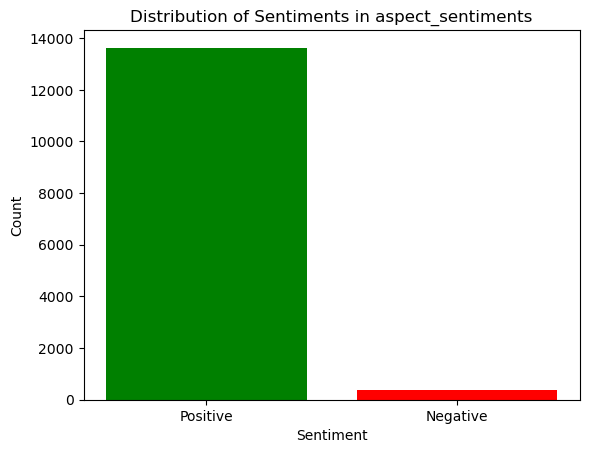

In [278]:

# Count positive and negative sentiments
positive_count = sum(sum(1 for val in row.values() if val == 'positive') for _, row in df_neutral['aspect_sentiments'].items())
negative_count = sum(sum(1 for val in row.values() if val == 'negative') for _, row in df_neutral['aspect_sentiments'].items())

# Plotting
labels = ['Positive', 'Negative']
values = [positive_count, negative_count]

plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in aspect_sentiments')
plt.show()


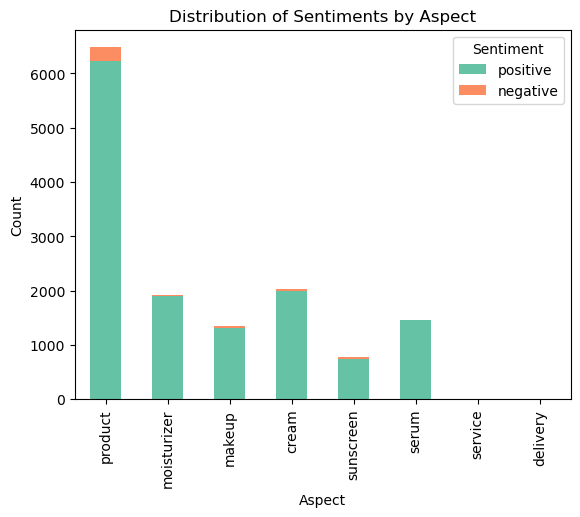

In [282]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Sample data (assuming your DataFrame df_neutral is already defined)

# Initialize counters
aspect_sentiment_counts = defaultdict(lambda: defaultdict(int))

# Iterate through each dictionary in the aspect_sentiments column
for sentiments in df_neutral['aspect_sentiments']:
    for aspect, sentiment in sentiments.items():
        aspect_sentiment_counts[aspect][sentiment] += 1

# Convert to DataFrame for easy plotting
df_counts = pd.DataFrame(aspect_sentiment_counts).T.fillna(0)

# Use pastel color scheme from Set3 colormap
colors = plt.cm.Set2.colors

# Plot
ax = df_counts.plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.title('Distribution of Sentiments by Aspect')
plt.legend(title='Sentiment')
plt.show()
